# importing needed libraries

In [1]:
import pandas as pd
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from skimage import exposure
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score


# load the data set 

In [2]:
# Load the dataset
dataset = pd.read_csv("dataset.csv")

## prepreation steps and extract HOG features

In [3]:
# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for img_pixels in images:
        img_pixels = np.array(img_pixels, dtype=np.uint8).reshape((48, 48))  #images are 48x48

        # Compute HOG features
        fd = hog(img_pixels, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                 block_norm='L2-Hys', visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)


In [14]:
# Select 5000 samples for each emotion [0, 2, 3] from the "Training" dataset for training
train_data = dataset[(dataset[' Usage'] == 'Training') & (dataset['emotion'].isin([0, 2, 3]))]
train_data = train_data.groupby('emotion').head(5000)

# Select 1000 samples for each emotion [0, 2, 3] from  "PrivateTest" for testing
test_data = dataset[(dataset[' Usage'].isin(['PrivateTest'])) & (dataset['emotion'].isin([0, 2, 3]))]
test_data = test_data.groupby([' Usage', 'emotion']).head(1000)

# Select 3000 samples for each emotion [0, 2, 3] from  "PublicTest" for validation 
val_data = dataset[(dataset[' Usage'].isin(['PublicTest','PrivateTest'])) & (dataset['emotion'].isin([0, 2, 3]))]
val_data = val_data.groupby([' Usage', 'emotion']).head(3000)

# Combine validation and training data for training purposes
combined_data = pd.concat([train_data, val_data])


In [22]:
# Calculate the number of samples used for training, validation, and testing
num_samples_training = len(train_data)
num_samples_validation = len(val_data)
num_samples_testing = len(test_data)

print("Samples Used:")
print(f"Training: {num_samples_training}")
print(f"Validation: {num_samples_validation}")
print(f"Testing: {num_samples_testing}")


Samples Used:
Training: 13092
Validation: 3756
Testing: 1898


In [23]:
# Count samples for each class in training data
train_samples_per_class = train_data.groupby('emotion').size().reset_index(name='count_train')

# Count samples for each class in validation data
val_samples_per_class = val_data.groupby('emotion').size().reset_index(name='count_val')

# Count samples for each class in testing data
test_samples_per_class = test_data.groupby('emotion').size().reset_index(name='count_test')

print("Samples Used per Class:")
print("Training:")
print(train_samples_per_class)
print("\nValidation:")
print(val_samples_per_class)
print("\nTesting:")
print(test_samples_per_class)


Samples Used per Class:
Training:
   emotion  count_train
0        0         3995
1        2         4097
2        3         5000

Validation:
   emotion  count_val
0        0        958
1        2       1024
2        3       1774

Testing:
   emotion  count_test
0        0         491
1        2         528
2        3         879


In [15]:
# Extract HOG features for training and testing data
images_train = combined_data[' pixels'].apply(lambda x: np.array(x.split(), dtype=float))
hog_features_train = extract_hog_features(images_train)

# Assign labels for training
labels_train = np.array(combined_data['emotion'])

# Extract HOG features for testing data
images_test = test_data[' pixels'].apply(lambda x: np.array(x.split(), dtype=float))
hog_features_test = extract_hog_features(images_test)

# Assign labels for testing data (if available)
labels_test = np.array(test_data['emotion'])

In [16]:
# Scale HOG features
scaler = StandardScaler()
scaled_hog_features_train = scaler.fit_transform(hog_features_train)
scaled_hog_features_test = scaler.transform(hog_features_test)


# Model 1 : logistic regression 

In [17]:
# Model Logistic Regression on Scaled HOG Features
log_reg_hog = LogisticRegression(max_iter=10000, solver = 'saga')  

# Train the model on scaled HOG features
log_reg_hog.fit(scaled_hog_features_train, labels_train)

# Predict on test set (scaled HOG features)
predictions_hog = log_reg_hog.predict(scaled_hog_features_test)

# Evaluate accuracy
accuracy_hog = accuracy_score(labels_test, predictions_hog)
print("Accuracy of Logistic Regression on Scaled HOG Features:", accuracy_hog*100)

Accuracy of Logistic Regression on Scaled HOG Features: 69.072708113804


### model Evaluation 

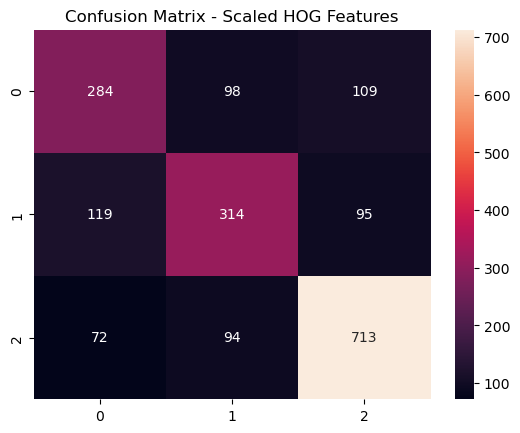

In [18]:
# Confusion Matrix
conf_matrix_hog = confusion_matrix(labels_test, predictions_hog)
sns.heatmap(conf_matrix_hog, annot=True, fmt='d')
plt.title("Confusion Matrix - Scaled HOG Features")
plt.show()


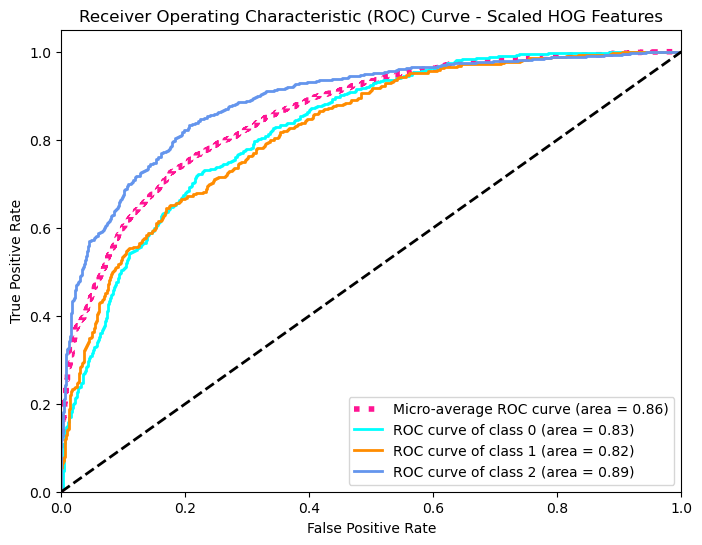

In [19]:
# Get predicted probabilities for each class
probabilities = log_reg_hog.predict_proba(scaled_hog_features_test)

# Binarize the labels
binary_labels = label_binarize(labels_test, classes=[0, 2, 3])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len([0, 2, 3])):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len([0, 2, 3])), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Scaled HOG Features')
plt.legend(loc="lower right")
plt.show()


# Model 2: KMEANS 

In [20]:
# Train KMeans on scaled HOG features
kmeans = KMeans(n_clusters=3, random_state=42) 
kmeans.fit(scaled_hog_features_train)

# Predict clusters for test set (scaled HOG features)
cluster_preds = kmeans.predict(scaled_hog_features_test)

cluster_to_label = {0: 0, 1: 2, 2: 3}  
# Map cluster labels to predicted labels for test set using the predefined mapping
predicted_labels_kmeans = [cluster_to_label[label] for label in cluster_preds]

# Evaluate accuracy
accuracy_kmeans = accuracy_score(labels_test, predicted_labels_kmeans)
print("Accuracy of KMeans as a Classifier on Scaled HOG Features:", accuracy_kmeans*100)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy of KMeans as a Classifier on Scaled HOG Features: 35.40569020021075


### Model Evaluation 

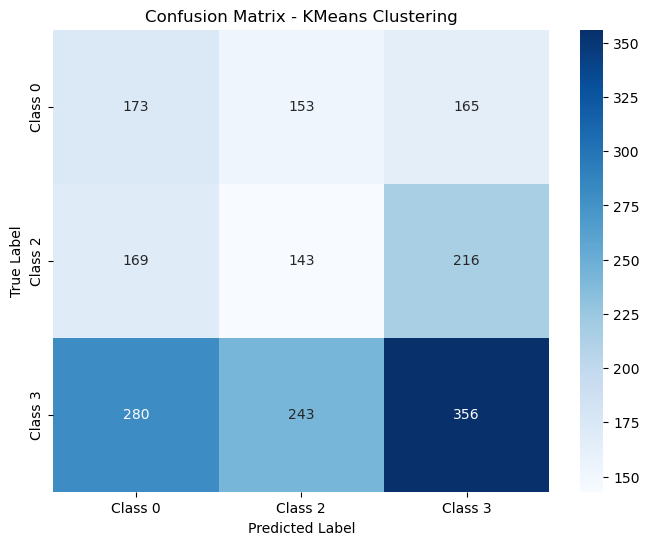

In [21]:
# Compute the confusion matrix
conf_matrix_kmeans = confusion_matrix(labels_test, predicted_labels_kmeans)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KMeans Clustering')
plt.show()


In [12]:
# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_hog_features_test, cluster_preds)
print(f"Silhouette Score for KMeans Clustering: {silhouette_avg}")


Silhouette Score for KMeans Clustering: 0.02440236669935575


In [13]:
# Calculate inertia
kmeans.fit(scaled_hog_features_train)
inertia = kmeans.inertia_
print(f"Inertia for KMeans Clustering: {inertia}")


D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Inertia for KMeans Clustering: 3191566.79673298
